In [1]:
# Set up plot stuff the DFM way:
%matplotlib inline
import matplotlib.pyplot as plt

%run ../document/figures/plot_setup.py

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Get target list; this follows the selection in ../document/figures/targets.py 

from __future__ import print_function, division
import sys
sys.path.append('..')

from peerless.catalogs import KICatalog, KOICatalog, EBCatalog, BlacklistCatalog
import numpy as np
import pandas as pd

stlr = KICatalog().df
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.
m &= stlr.kepmag < 15.

# known EBs
ebs = set(np.array(EBCatalog().df["#KIC"]))

# KOI false positives
kois = KOICatalog().df
kois = kois[kois.koi_disposition == "FALSE POSITIVE"]
fps = set(np.array(kois.kepid))

# And then finally the blacklist.
bl = set(np.array(BlacklistCatalog().df.kicid))

# The full list of ignores.
ignore = fps | bl #ebs | fps | bl  #Don't ignore EBs for purposes of prediction
m &= ~stlr.kepid.isin(ignore)

targets = stlr[m]

In [3]:
targets[['kepid','mass','feh']].count()

kepid    39626
mass     38983
feh      39626
dtype: int64

In [4]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import TRILEGAL_BGPowerLawBinaryPopulation

ebpop = KeplerPowerLawBinaryPopulation(targets, ecc_empirical=True)
bgstars = pd.read_hdf('bgstars.h5', 'df')
bgpop = TRILEGAL_BGPowerLawBinaryPopulation(targets, bgstars, ecc_empirical=True, use_ic=True)

104.739898977
121


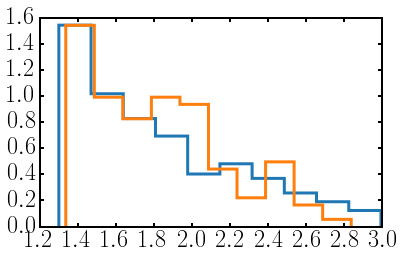

In [12]:
from __future__ import division

min_period = 20
max_period = 15*365.25
ebpop.set_params(beta=-0.95, period_min=min_period, period_max=max_period, fB=0.14)

q = 'period > {} and period < 1000 and '.format(min_period) +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'

kep_ebs = EBCatalog().df.query('{} < period < 1000'.format(min_period))
n_exp = len(kep_ebs) * (len(targets)/len(KICatalog().df))
print(n_exp)
plt.hist(np.log10(kep_ebs.period), 
         histtype='step', lw=3, normed=True);
new_obs = ebpop.observe(new_orbits=True).query(q)
plt.hist(np.log10(new_obs.period),
        histtype='step', lw=3, normed=True);
print(len(new_obs))

In [13]:
ebpop.params

{'beta': -0.95,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.14,
 'gamma': 0.3,
 'period_max': 5478.75,
 'period_min': 20,
 'qmin': 0.1}

In [14]:
# Set params to match above
pars = dict(period_min=20, period_max=15*365.25, beta=-0.95, fB=0.14)
ebpop.set_params(**pars)
bgpop.set_params(**pars)
ebpop._generate_binaries()
bgpop._generate_binaries()

Let's do a bunch of these observation simulations and see what it looks like:

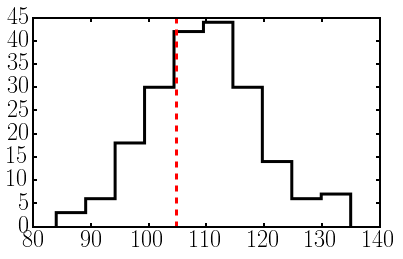

In [15]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(200)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

OK, now that we can roughly match the Kepler EB catalog from 10 to 1000d with these EB population parameters, we want to know what's the typical number of single/double eclipse signals.

In [16]:
ebpop._train_trap(N=1000);
bgpop._train_trap(N=1000);

EB: Depth trained: R2=0.998098072353
EB: Duration trained: R2=0.953733923826
EB: Slope trained: R2=0.761430316126
BGEB: Depth trained: R2=0.999606420731
BGEB: Duration trained: R2=0.998523699654
BGEB: Slope trained: R2=0.978825206063


In [17]:
dfm_q = 'n_pri < 3 and n_sec < 3 and ((n_pri==0 and snr_sec > 15) or (n_sec==0 and snr_pri > 15))'
dfm_q += ' and ((T14_pri < 2.5 and n_pri > 0) or (T14_sec < 2.5 and n_sec > 0))'
nobs_eb = [len(ebpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(200)]
nobs_bg = [len(bgpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(200)]

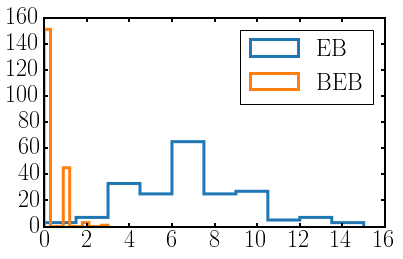

In [18]:
plt.hist(nobs_eb, histtype='step', lw=3, label='EB');
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB');
plt.legend();

OK, now let's determine the typical shapes.  Let's do this with a big sample of simulated observations.

In [121]:
np.mean(nobs_eb), np.mean(nobs_bg)

(6.5700000000000003, 0.27000000000000002)

In [19]:
eb_obs = ebpop.get_N_observed(query=dfm_q, N=2000, new_orbits=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=200, use_ic=True, new_orbits=True) #takes longer; use fewer

OK, now let's load up the candidates.

In [20]:
candidates = pd.read_csv('../results/candidates.csv').query('accept_bic and accept_time and num_peaks <= 2')
candidates[['depth','transit_duration','s2n']].head()

,depth,transit_duration,s2n
17,0.003340,0.393807,52.678551
27,0.078353,1.157742,803.421212
39,0.015872,0.684503,392.762344
40,0.015061,0.684186,390.821950
43,0.023301,0.361075,632.248098


In [21]:
candidates.s2n.min()

18.096212254112913

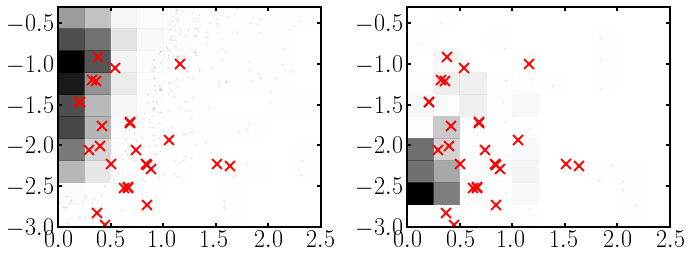

In [110]:
from corner import hist2d

fix, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

hist2d(eb_obs.observed.dur_pri.values, eb_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax1, range=[(0,2.5), (-3, -0.3)], bins=10);
hist2d(bg_obs.observed.dur_pri.values, bg_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax2, range=[(0,2.5), (-3, -0.3)], bins=10);

for ax in (ax1, ax2):
    ax.plot(candidates.transit_duration, np.log10(candidates.transit_depth), 'rx', ms=10)


In [24]:
from scipy.stats import gaussian_kde

eb_kde = gaussian_kde(np.array([eb_obs.observed.dur_pri, eb_obs.observed.logd_pri]))
bg_kde = gaussian_kde(np.array([bg_obs.observed.dur_pri, bg_obs.observed.logd_pri]))

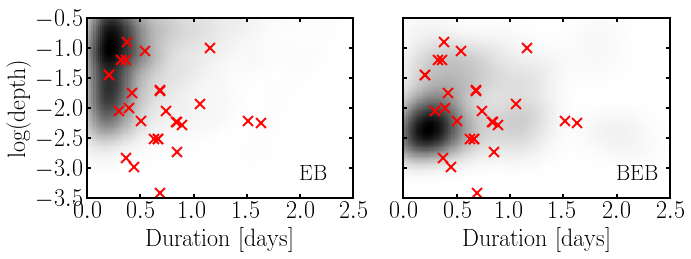

In [113]:
def plot_kde(kde, ax=None, dur_range=(0,2.5), depth_range=(-3.5,-0.5), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.transit_duration, np.log10(cands.transit_depth), 'rx', ms=10)
    
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)

In [27]:
len(candidates)

27

In [28]:
from exosyspop.populations import PoissonPlanetPopulation

Rp_min = 0.1 * 11.2 # 0.1 RJ
Rp_max = 11.2 # RJ

plpop = PoissonPlanetPopulation(targets, period_min=2*365.25, period_max=15*365.25,
                                   Rp_min=Rp_min, Rp_max = Rp_max)

In [29]:
plpop._train_trap(N=1000)

Planet: Depth trained: R2=0.997254547441
Planet: Duration trained: R2=0.989982151104
Planet: Slope trained: R2=0.977031732341


(Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, cri

In [30]:
plpop.params

{'N_pl': 1.0,
 'Rp_max': 11.2,
 'Rp_min': 2.2399999999999998,
 'alpha': -1.6,
 'beta': -0.75,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'period_max': 5478.75,
 'period_min': 730.5}

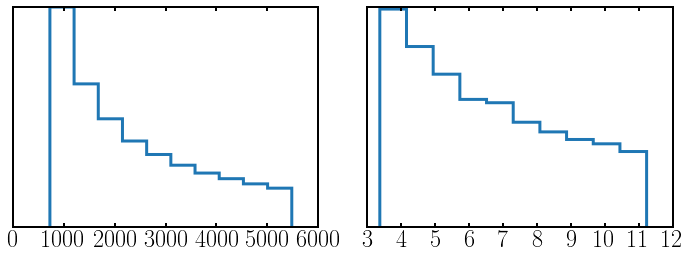

In [92]:
# OK, checking out a hypothetical planet population
# Rp from 0.3 to 1 RJup
plpop.set_params(alpha=-1, Rp_min=0.3*11.2, Rp_max=11.2, beta=-1.0, N_pl=0.5)
plpop._generate_planets()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(plpop.period, histtype='step', lw=3);
ax1.set_yticks([])
ax2.hist(plpop.radius_B*6.96e10/6.37e8, histtype='step', lw=3);
ax2.set_yticks([]);


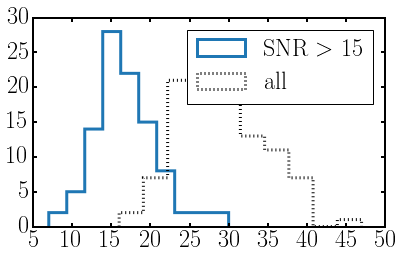

In [97]:
dfm_q_pl = 'n_pri < 3 and snr_pri > 15 and T14_pri < 2.5'
dfm_q_pl_nosnr = 'n_pri < 3 and T14_pri < 2.5 and snr_pri > 0'

nobs_pl = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl)) for i in range(100)]
nobs_pl2 = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl_nosnr)) for i in range(100)]

plt.hist(nobs_pl, histtype='step', lw=3, label='SNR $>$ 15');
plt.hist(nobs_pl2, histtype='step', lw=3, color='k', ls=':', label='all')
plt.legend(loc='upper right');

In [122]:
np.mean(nobs_pl)

16.780000000000001

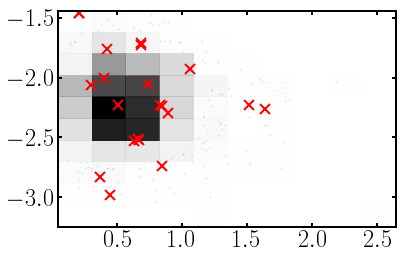

In [108]:
N = 1000
pl_obs = plpop.get_N_observed(query=dfm_q_pl, N=N)

hist2d(pl_obs.observed.dur_pri.values, pl_obs.observed.logd_pri.values,
          plot_contours=False, bins=10);

plt.plot(candidates.transit_duration, np.log10(candidates.transit_depth), 'rx', ms=10);

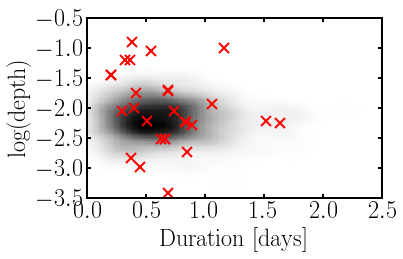

In [114]:
pl_kde = gaussian_kde(np.array([pl_obs.observed.dur_pri, pl_obs.observed.logd_pri]))
plot_kde(pl_kde)

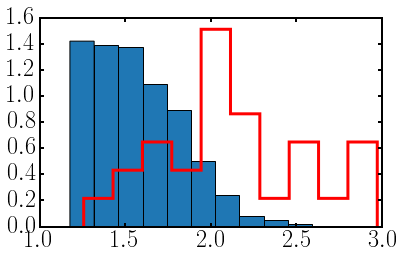

In [96]:
plt.hist(np.log10(pl_obs.observed.snr_pri), normed=True);
plt.hist(np.log10(candidates.s2n.values), histtype='step', color='r', lw=3, normed=True);

OK, now we can guess as to the nature of each individual signal, given our predicted rates and the depth-duration shape information:

In [127]:
pts = [candidates.transit_duration, np.log10(candidates.transit_depth)]
L_eb = eb_kde(pts)
L_bg = bg_kde(pts)
L_pl = pl_kde(pts)

pi_eb = 7.
pi_bg = 0.25
pi_pl = 20

norm = L_eb*pi_eb + L_bg*pi_bg + L_pl*pi_pl

candidates['pr_eb'] = L_eb*pi_eb / norm
candidates['pr_bg'] = L_bg*pi_bg / norm
candidates['pr_pl'] = L_pl*pi_pl / norm

In [132]:
candidates[['pr_eb', 'pr_bg', 'pr_pl']].sum()

pr_eb     7.967018
pr_bg     0.845612
pr_pl    18.187371
dtype: float64

In [129]:
candidates[['transit_depth', 'transit_duration', 'pr_eb', 'pr_bg', 'pr_pl']]

,transit_depth,transit_duration,pr_eb,pr_bg,pr_pl
17,0.009891,0.393807,0.100521,0.006526,8.929526e-01
27,0.099859,1.157742,0.983571,0.016429,1.625674e-10
39,0.019413,0.684503,0.119688,0.007541,8.727710e-01
40,0.018614,0.684186,0.105281,0.006634,8.880846e-01
43,0.061088,0.361075,0.985850,0.013016,1.134098e-03
135,0.001466,0.368496,0.038147,0.019330,9.425233e-01
139,0.005940,0.504267,0.034349,0.004657,9.609945e-01
146,0.008761,0.736594,0.018510,0.001806,9.796848e-01
151,0.005943,1.514634,0.020482,0.003661,9.758570e-01
186,0.008697,0.295183,0.152245,0.008694,8.390618e-01
